## LandCoverNet Data Exploration

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

This tutorial delves into building a scalable model on the LandCoverNet dataset.

In this notebook, a portion of the tutorial:

1. We will authenticate to MLHub via the API key to make requests on the LandCoverNet label collection

2. We will download the label collection into PC

3. We will perform some exploratory data analysis on these labels to get a better understanding of the LandCoverNet data


### Citation

Alemohammad S.H., Ballantyne A., Bromberg Gaber Y., Booth K., Nakanuku-Diggs L., & Miglarese A.H. (2020) [LandCoverNet: A Global Land Cover Classification Training Dataset](https://arxiv.org/abs/2012.03111), Version 1.0, Radiant MLHub. https://doi.org/10.34911/rdnt.d2ce8i

The [LandCoverNet Dataset on Radiant MLHub](tutorials/radiant-mlhub-landcovernet.ipynb) tutorial discusses setting up your authorization, listing collection properties, and retrieving the items (the data contained within them) from the collections of LandCoverNet dataset. Most requests to MLHub in this notebook will be based off this tutorial.

### Authentication

Access to the Radiant MLHub API requires an API key. To get your API key, go to [mlhub.earth](https://mlhub.earth/) and click the "Sign in / Register" button in the top right to log in. If you have not used Radiant MLHub before, you will need to sign up and create a new account; otherwise, just sign in. Once you have signed in, click on your user avatar in the top right and select the "Settings & API keys" from the dropdown menu.

In the **API Keys** section of this page, you will be able to create new API key(s). *Do not share* your API key with others as this may pose a security risk.

Next, we will create a `MLHUB_API_KEY` variable that `pystac-client` will use later use to add our API key to all requests:

In [1]:
import getpass

MLHUB_API_KEY = getpass.getpass(prompt="MLHub API Key: ")
MLHUB_ROOT_URL = "https://api.radiant.earth/mlhub/v1"

MLHub API Key:  ································································


There are a number of STAC and geospatial related libraries used in this notebook that need to be imported.

In [2]:
import os
import requests
import pystac
import rioxarray
import shapely.geometry
import rasterio.plot
import tarfile
import shutil
import tempfile
from pathlib import Path
import itertools as it
from urllib.parse import urljoin
from ipyleaflet import Map, GeoJSON

from pystac import Item
from pystac.extensions.eo import EOExtension
from pystac.extensions.label import LabelExtension, LabelRelType
from pystac.extensions.scientific import ScientificExtension
from pystac_client import Client

In order to connect to the MLHub API, we can use the `pystac_client` library to instantiate a client that simplifies the process of querying available STAC Catalogs/Collections over a specified end-point.

In [3]:
client = Client.open(
    MLHUB_ROOT_URL, parameters={"key": MLHUB_API_KEY}, ignore_conformance=True
)

This is a helper function to instantiate a requests session with the MLHub API directly vs. using the `pystac_client` API client above.

In [4]:
class MLHubSession(requests.Session):
    def __init__(self, *args, api_key=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.params.update({"key": api_key})

    def request(self, method, url, *args, **kwargs):
        url_prefix = MLHUB_ROOT_URL.rstrip("/") + "/"
        url = urljoin(url_prefix, url)
        return super().request(method, url, *args, **kwargs)


session = MLHubSession(api_key=MLHUB_API_KEY)

### Listing Collection Properties

The following cell makes a request to the API and displays the metadata for the LandCoverNet labels Collection.

In [5]:
collection_id = "ref_landcovernet_v1_labels" #collections for the labels

collection = client.get_collection(collection_id)
collection_sci_ext = ScientificExtension.ext(collection)
print(f"Description: {collection.description}")
print(f"License: {collection.license}")
print(f"DOI: {collection_sci_ext.doi}")
print(f"Citation: {collection_sci_ext.citation}")

Description: LandCoverNet Labels
License: CC-BY-4.0
DOI: 10.34911/rdnt.d2ce8i
Citation: Alemohammad S.H., Ballantyne A., Bromberg Gaber Y., Booth K., Nakanuku-Diggs L., & Miglarese A.H. (2020) "LandCoverNet: A Global Land Cover Classification Training Dataset", Version 1.0, Radiant MLHub. [Date Accessed] https://doi.org/10.34911/rdnt.d2ce8i


### Finding Possible Land Cover Labels

Each label item within the collection has a property which lists all of the possible land cover types and which ones are present in each label item. The code below prints out which land cover types are present in the dataset and we will reference these later in the notebook when we filter downloads.

In [6]:
item_search = client.search(collections=[collection_id])

first_item = next(item_search.get_items())
first_item_label_ext = LabelExtension.ext(first_item)

label_classes = first_item_label_ext.label_classes
for label_class in label_classes:
    print(f"Classes for {label_class.name}")
    for c in sorted(label_class.classes):
        print(f"- {c}")

Classes for labels
- (Semi) Natural Vegetation
- Artificial Bareground
- Cultivated Vegetation
- Natural Bareground
- No Data
- Permanent Snow/Ice
- Water
- Woody Vegetation


### Downloading Label Collections

Next, we will download the label collections into a directory on PC.

First, we can check the active directory on Planetary Computer, and designate a temporary folder where we will download the label collection.

In [7]:
!pwd

/home/jovyan/PlanetaryComputerExamples


In [7]:
tmp_dir = "/home/jovyan/PlanetaryComputerExamples"
if not os.path.isdir(f"{tmp_dir}/landcovnet/labels"):
    os.makedirs(f"{tmp_dir}/landcovnet/labels") #create folder for labels to be stored

This simple request GETs the high-level LandCoverNet label metadata

In [7]:
response = session.get(f"/archive/{collection_id}/info")
response.json()

{'collection': 'ref_landcovernet_v1_labels',
 'dataset': 'landcovernet_v1',
 'size': 19205520,
 'types': ['labels']}

With the collection validated, we need to download the labels collection archive.

In [37]:
archive_path = os.path.join(tmp_dir+"/landcovnet/labels", f"{collection_id}.tar.gz")
response = session.get(f"/archive/{collection_id}", allow_redirects=True)
with open(archive_path, "wb") as dst:
    dst.write(response.content)

Because the archived file is compressed into `.tar.gz` we need to uncompress it into a directory of JSON files

In [ ]:
# open file
file = tarfile.open(tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels.tar.gz")
# extract files
file.extractall(tmp_dir+"/landcovnet/labels/") #extract labels

Now that the labels collection has been downloaded, we want to make sure the correct count of files is present.

In [11]:
import os
files = os.listdir(tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels")
file_count = len(files) #we expect 1982 files
file_count

1982

### Exploration on Sample Label

Next, we will inspect a label item for its bands and visualise the label

In [19]:
file= tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_36MWT_15/labels.tif"
label_item = file
labels = rioxarray.open_rasterio(label_item).squeeze()

In [23]:
labels

<xarray.DataArray (band: 2, y: 256, x: 256)>
[131072 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2
  * x            (x) float64 6.026e+05 6.026e+05 ... 6.052e+05 6.052e+05
  * y            (y) float64 9.239e+06 9.239e+06 ... 9.237e+06 9.237e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

By default the LandCoverNet label `.tif` files have two bands, one for the label classification, and an accompanying band for the consensus score of the manual classification performed that ranges from 0-100. For the purposes of this notebook, let's just take a look at the first band with the actual classes associated to each pixel in the chip.

In [28]:
labels=labels[0] #we want the first band of the label

In [29]:
labels

<xarray.DataArray (y: 256, x: 256)>
array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [7, 5, 5, ..., 5, 5, 7],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 7, 7, 7]], dtype=uint16)
Coordinates:
    band         int64 1
  * x            (x) float64 6.026e+05 6.026e+05 ... 6.052e+05 6.052e+05
  * y            (y) float64 9.239e+06 9.239e+06 ... 9.237e+06 9.237e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

For visualization purposes, we can manually map all of the valid class names from the dataset.

In [34]:
classes=[
    'No Data',
    'Water',
    'Artificial Bareground',
    'Natural Bareground',
    'Permanent Snow/Ice',
    'Woody Vegetation',
    'Cultivated Vegetation',
    '(Semi) Natural Vegetation'
]

### Data Visualisation

Here:

1. We will visualise a sample label with its respective classes. The choice of colours for the label classes were based on the documentation which can be seen in the /_common/documentation.pdf path in the labels directory 

2. We will then view the geographic locations of every label item in our collection

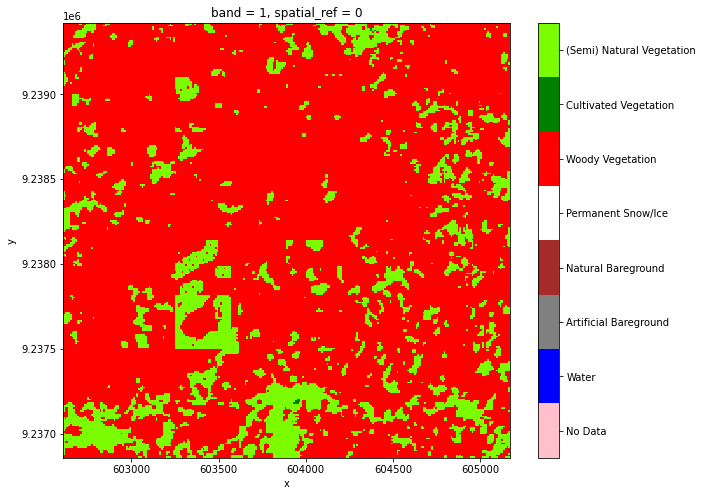

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(10, 8))
cMap = ListedColormap(['pink','blue', 'grey', 'brown', 'white', 'red', 'green', 'lawngreen'])
p = labels.plot.imshow(
    ax=ax, cmap=cMap, add_colorbar=False, vmin=0, vmax=len(classes)
)
cbar = plt.colorbar(p)
cbar.set_ticks(np.arange(0.5, len(classes) + 0.5))
cbar.set_ticklabels(classes);

In [8]:
training_catalog = pystac.read_file(
    tmp_dir+"/landcovnet/labels/ref_landcovernet_v1_labels/collection.json"
)
links = training_catalog.get_item_links()
label_item = next(training_catalog.get_all_items())

In [24]:
label_item

<Item id=ref_landcovernet_v1_labels_35PRL_27>

With a single label Item selected from the collection, we can visualize this on a map using the ipyleaflet library.

In [28]:
links = training_catalog.get_item_links()
label_items = [link.resolve_stac_object().target for link in links]

data = {
    "type": "FeatureCollection",
    "features": [],
}
for label_item in label_items:
    data["features"].append(label_item.geometry)


center = shapely.geometry.shape(label_item.geometry).centroid.bounds[:2][::-1]

m = Map(center=(5.507814018809909, 13.617742928307308), zoom=2)
layer = GeoJSON(data=data)

m.add_layer(layer)
m.layout.max_width = "600px"

m

Map(center=[5.507814018809909, 13.617742928307308], controls=(ZoomControl(options=['position', 'zoom_in_text',…